<a href="https://colab.research.google.com/gist/janlukasschroeder/535cb89b7e75275799892071b71f80cb/8k-item-4-02-tutorial-website.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


TODO: update link for colab


# Analysis of Accountant Changes and Disagreement Reports

We illustrate how to perform an exploratory data analysis on disclosures informing investors about changes of accountant and potential disagreements with the former accountant of publicly traded companies on U.S. stock exchanges. These changes are disclosed in Form 8-K filings with the SEC, specifically under Item 4.01, titled "Changes in Registrant’s Certifying Accountant." These disclosures are presented in text form by companies. Utilizing our Structured Data API, we extract and structure the relevant information from the text, making it available for detailed analysis.

Our analysis will focus on several key areas:

- Number of Item 4.01 disclosures made each year from 2004 to 2023, per quarter, month and at what time of the day (pre-market, regular market, after-market)
- Distribution of disclosures across structured data fields, such as the proportion of disclosures reporting a going concern
- Number of disagreements and resolution thereof disclosed per year
- Disclosed weaknesses in internal control over financial reporting (ICFR)
- Identification of the reason for the termination of the engagement with the former accountant
- Identification of the types of opinion expressed in the audit reports


## Data Loading and Preparation

To load and prepare the data, we will use the [Form 8-K Item 4.01 Structured Data API](https://sec-api.io/docs/form-8k-data-search-api) (TODO: fix link) to download all structured data related to Form 8-K filings that include Item 4.01 disclosures. For the sake of brevity, the data spanning the years 2004 to 2023 has already been preprocessed and saved in a CSV file, allowing us to jump directly into the analysis phase.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.ticker as mtick

style.use("default")

params = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "grid.color": "grey",
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.5,
    "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [ ]:
unique_years = structured_data["year"].nunique()
unique_companies = structured_data["companyName"].nunique()
print(
    f"Loaded {len(structured_data):,} structured data records from 2004 to 2023, covering {unique_years} years and {unique_companies} unique companies."
)
structured_data.head()

Loaded 25,792 structured data records from 2004 to 2023, covering 20 years and 12526 unique companies.


,accessionNo,filedAt,periodOfReport,formType,cik,ticker,companyName,items,keyComponents,newAccountantDate,...,opinionsType,dismissalReason,dismissalDate,dismissedAccountantName,newAccountantName2,year,month,qtr,filedAt_local,filedAtClass
0,0001059677-04-000020,2004-12-30T16:40:19-05:00,2004-12-29,8-K,1059677,IEAM,ADVANCED BIO/CHEM INC,"[""Item 4.01: Changes in Registrant's Certifyin...","On December 29, 2004, Fitts, Roberts & Co., P....",2004-12-09,...,NaN,NaN,NaN,NaN,NaN,2004,12,4,2004-12-30 16:40:19,afterMarket
1,0001059677-04-000012,2004-12-27T20:17:16-05:00,2004-12-08,8-K,1059677,IEAM,ADVANCED BIO/CHEM INC,"[""Item 4.01: Changes in Registrant's Certifyin...",Lazar Levine and Felix LLP resigned as Industr...,2004-10-11,...,NaN,NaN,NaN,NaN,NaN,2004,12,4,2004-12-27 20:17:16,other
2,0000950152-06-009998,2006-12-08T17:06:08-05:00,2006-12-05,8-K,1059677,IEAM,"Industrial Enterprises of America, Inc.","[""Item 4.01: Changes in Registrant's Certifyin...","Beckstead and Watts, LLP informed the Company ...",2006-12-08,...,NaN,NaN,NaN,NaN,NaN,2006,12,4,2006-12-08 17:06:08,afterMarket
3,0001170918-04-000790,2004-12-30T16:36:41-05:00,2004-12-30,8-K,1022844,NaN,BRILLIANT DIGITAL ENTERTAINMENT INC,"[""Item 4.01: Changes in Registrant's Certifyin...","Effective December 30, 2004, BDO Seidman, LLP ...",2004-12-30,...,NaN,NaN,NaN,NaN,NaN,2004,12,4,2004-12-30 16:36:41,afterMarket
4,0001193125-04-221654,2004-12-30T16:30:31-05:00,2004-12-30,8-K,1101433,QMCI,QUOTEMEDIA INC,"[""Item 4.01: Changes in Registrant's Certifyin...","QuoteMedia, Inc. engaged Hein & Associates LLP...",2004-12-30,...,NaN,NaN,NaN,NaN,NaN,2004,12,4,2004-12-30 16:30:31,afterMarket


## Vizualization of Change-of-Accountant Disclosures over Time


In [4]:
item_4_01_counts = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year"])
    .size()
    .to_frame(name="count")
)

print(f"Item 4.01 counts from 2004 to 2023.")
item_4_01_counts.T

Item 4.01 counts from 2004 to 2023.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,771,2108,2180,1978,1636,2108,1648,1458,1178,1575,1414,1220,957,983,837,720,606,775,795,845


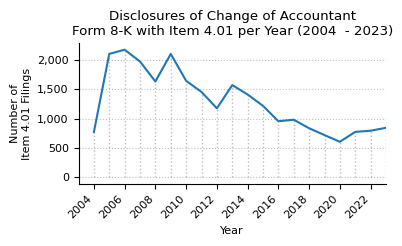

In [5]:
def plot_timeseries(ts, title):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ts["count"].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of\nItem 4.01 Filings")
    ax.set_xticks(np.arange(2004, 2024, 2))
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.set_xlim(2003, 2023)
    ax.grid(axis="x")
    ax.set_axisbelow(True)
    plt.xticks(rotation=45, ha="right")

    for year in range(2004, 2024, 1):
        year_y_max = ts.loc[year, "count"]
        ax.vlines(year, 0, year_y_max, linestyles=":", colors="grey", alpha=0.5, lw=1)

    plt.tight_layout()
    plt.show()


plot_timeseries(
    item_4_01_counts,
    title="Disclosures of Change of Accountant\nForm 8-K with Item 4.01 per Year (2004  - 2023)",
)

In [6]:
structured_data["qtr"] = structured_data["month"].apply(lambda x: (x - 1) // 3 + 1)

counts_qtr_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "qtr"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

print(f"Item 4.01 counts by quarter from 2004 to 2023.")
counts_qtr_yr_piv.T

Item 4.01 counts by quarter from 2004 to 2023.


year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
qtr,,,,,,,,,,,,,,,,,,,,
1,0,464,587,573,532,388,494,481,307,441,445,315,245,257,244,191,184,173,164,175
2,0,634,607,528,390,436,381,417,270,423,333,339,292,260,217,234,157,185,198,235
3,227,550,498,439,322,791,413,233,252,377,338,313,188,224,183,149,111,223,216,211
4,544,460,488,438,392,493,360,327,349,334,298,253,232,242,193,146,154,194,217,224


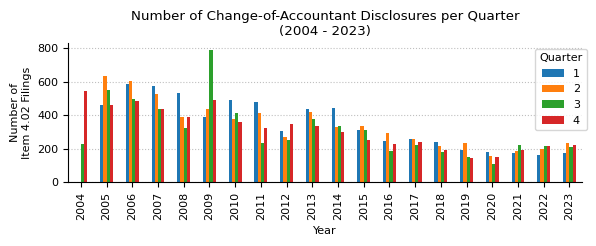

In [ ]:
counts_qtr_yr = counts_qtr_yr_piv.stack().reset_index(name="count")

fig, ax = plt.subplots(figsize=(6, 2.5))
counts_qtr_yr_piv.plot(kind="bar", ax=ax, legend=True)
ax.legend(title="Quarter", loc="upper right", bbox_to_anchor=(1.02, 1))
ax.set_title("Number of Change-of-Accountant Disclosures per Quarter\n(2004 - 2023)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of\nItem 4.01 Filings")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.grid(axis="x")
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [8]:
counts_month_yr_piv = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["year", "month"])
    .size()
    .unstack()
    .fillna(0)
).astype(int)

print(f"Item 4.01 counts by month from 2004 to 2023.")
counts_month_yr_piv

Item 4.01 counts by month from 2004 to 2023.


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2004,0,0,0,0,0,0,0,61,166,211,174,159
2005,130,156,178,218,186,230,177,209,164,151,178,131
2006,189,155,243,209,202,196,164,167,167,160,155,173
2007,175,203,195,201,185,142,157,146,136,174,147,117
2008,212,158,162,149,129,112,110,103,109,130,141,121
2009,142,94,152,185,141,110,127,329,335,287,105,101
2010,190,119,185,160,114,107,112,174,127,131,114,115
2011,154,124,203,173,116,128,86,81,66,95,126,106
2012,78,91,138,105,86,79,67,112,73,114,123,112


In [9]:
print(f"Descriptive statistics for Item 4.01 counts by month from 2004 to 2023.")
month_stats = (
    counts_month_yr_piv.loc[2004:]
    .describe(percentiles=[0.025, 0.975])
    .round(0)
    .astype(int)
)
month_stats

Descriptive statistics for Item 4.01 counts by month from 2004 to 2023.


month,1,2,3,4,5,6,7,8,9,10,11,12
count,20,20,20,20,20,20,20,20,20,20,20,20
mean,108,94,131,123,102,102,95,113,105,117,102,98
std,60,51,59,59,52,50,46,69,68,59,43,34
min,0,0,0,0,0,0,0,29,36,49,32,43
2.5%,19,19,36,26,16,30,22,37,36,51,38,45
50%,94,92,126,114,98,98,86,104,86,107,100,96
97.5%,202,182,224,214,194,214,171,272,255,251,176,166
max,212,203,243,218,202,230,177,329,335,287,178,173


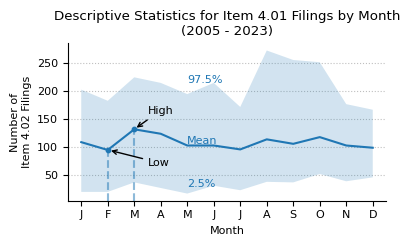

In [ ]:
def plot_box_plot_as_line(
    data: pd.DataFrame,
    x_months=True,
    title="",
    x_label="",
    x_pos_mean_label=2,
    pos_labels=None,  # {"mean": {"x": 2, "y": 150}, "upper": {"x": 2, "y": 150}, "lower": {"x": 2, "y": 150}},
    pos_high_low=None,  # {"high": {"x": 2, "y": 150}, "low": {"x": 2, "y": 150}},
    y_label="",
    y_formatter=lambda x, p: "{:.0f}".format(int(x) / 1000),
    show_high_low_labels=True,
    show_inline_labels=True,
    show_bands=True,
    figsize=(4, 2.5),
    line_source="mean",
):
    fig, ax = plt.subplots(figsize=figsize)

    line_to_plot = data[line_source]
    lower_label = "2.5%"
    upper_label = "97.5%"
    lower = data[lower_label]
    upper = data[upper_label]

    line_to_plot.plot(ax=ax)

    if show_bands:
        ax.fill_between(line_to_plot.index, lower, upper, alpha=0.2)

    if x_months:
        ax.set_xlim(0.5, 12.5)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(y_formatter))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    ymin, ymax = ax.get_ylim()
    y_scale = ymax - ymin

    max_x = int(line_to_plot.idxmax())
    max_y = line_to_plot.max()
    min_x = int(line_to_plot.idxmin())
    min_y = line_to_plot.min()

    ax.axvline(
        max_x,
        ymin=0,
        ymax=((max_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(max_x, max_y, color="tab:blue", s=10)
    ax.axvline(
        min_x,
        ymin=0,
        ymax=((min_y - ymin) / (ymax - ymin)),
        linestyle="dashed",
        color="tab:blue",
        alpha=0.5,
    )
    ax.scatter(min_x, min_y, color="tab:blue", s=10)

    x_pos_mean_label_int = int(x_pos_mean_label)
    if show_inline_labels:
        mean_x = x_pos_mean_label
        mean_y = line_to_plot.iloc[x_pos_mean_label_int] * 1.02
        upper_x = x_pos_mean_label
        upper_y = upper.iloc[x_pos_mean_label_int]
        lower_x = x_pos_mean_label
        lower_y = lower.iloc[x_pos_mean_label_int] * 0.95

        if pos_labels:
            mean_x = pos_labels["mean"]["x"]
            mean_y = pos_labels["mean"]["y"]
            upper_x = pos_labels["upper"]["x"]
            upper_y = pos_labels["upper"]["y"]
            lower_x = pos_labels["lower"]["x"]
            lower_y = pos_labels["lower"]["y"]

        ax.text(mean_x, mean_y, "Mean", color="tab:blue", fontsize=8)
        ax.text(upper_x, upper_y, upper_label, color="tab:blue", fontsize=8)
        ax.text(lower_x, lower_y, lower_label, color="tab:blue", fontsize=8)

    if show_high_low_labels:
        high_x_origin = max_x
        high_y_origin = max_y
        high_x_label = high_x_origin + 0.5
        high_y_label = high_y_origin + 0.1 * y_scale
        if pos_high_low:
            high_x_label = pos_high_low["high"]["x"]
            high_y_label = pos_high_low["high"]["y"]
        ax.annotate(
            "High",
            (high_x_origin, high_y_origin),
            xytext=(high_x_label, high_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

        low_x_origin = min_x * 1.01
        low_y_origin = min_y
        low_x_label = low_x_origin + 1.5
        low_y_label = low_y_origin - 0.1 * y_scale
        if pos_high_low:
            low_x_label = pos_high_low["low"]["x"]
            low_y_label = pos_high_low["low"]["y"]
        ax.annotate(
            "Low",
            (low_x_origin, low_y_origin),
            xytext=(low_x_label, low_y_label),
            arrowprops=dict(facecolor="black", arrowstyle="->"),
        )

    ax.grid(axis="x")
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


plot_box_plot_as_line(
    data=month_stats.T,
    title="Descriptive Statistics for Item 4.01 Filings by Month\n(2005 - 2023)",
    x_label="Month",
    y_label="Number of\nItem 4.01 Filings",
    y_formatter=lambda x, p: "{:.0f}".format(int(x)),
    x_pos_mean_label=5,
)

In [11]:
counts_filedAtClass = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["filedAtClass"])
    .size()
    .sort_values(ascending=False)
    .to_frame(name="Count")
).rename_axis("Publication Time")
counts_filedAtClass["Pct"] = (
    counts_filedAtClass["Count"].astype(int)
    / counts_filedAtClass["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_filedAtClass["Count"] = counts_filedAtClass["Count"].map(lambda x: f"{x:,}")
counts_filedAtClass.index = (
    counts_filedAtClass.index.str.replace("preMarket", "Pre-Market (4:00 - 9:30 AM)")
    .str.replace("marketHours", "Market Hours (9:30 AM - 4:00 PM)")
    .str.replace("afterMarket", "After Market (4:00 - 8:00 PM)")
)
counts_filedAtClass = counts_filedAtClass.reindex(counts_filedAtClass.index[::-1])

print(
    f"Item 4.01 counts by pre-market, regular market hours,\nand after-market publication time (2004 - 2023)."
)
counts_filedAtClass

Item 4.01 counts by pre-market, regular market hours,
and after-market publication time (2004 - 2023).


,Count,Pct
Publication Time,,
other,613,2%
Pre-Market (4:00 - 9:30 AM),"1,564",6%
Market Hours (9:30 AM - 4:00 PM),"10,580",41%
After Market (4:00 - 8:00 PM),"13,035",51%


In [12]:
structured_data.loc[:, "dayOfWeek"] = structured_data["filedAt_local"].dt.strftime("%a")

counts_dayOfWeek = (
    structured_data.drop_duplicates(subset=["accessionNo"])
    .groupby(["dayOfWeek"])
    .size()
    .to_frame(name="Count")
).rename_axis("Day of the Week")
counts_dayOfWeek["Pct"] = (
    counts_dayOfWeek["Count"].astype(int) / counts_dayOfWeek["Count"].astype(int).sum()
).map("{:.0%}".format)
counts_dayOfWeek["Count"] = counts_dayOfWeek["Count"].map(lambda x: f"{x:,}")

print(f"Item 4.01 disclosures by day of the week (2004 - 2023).")
counts_dayOfWeek.loc[["Mon", "Tue", "Wed", "Thu", "Fri"]]

Item 4.01 disclosures by day of the week (2004 - 2023).


,Count,Pct
Day of the Week,,
Mon,"4,668",18%
Tue,"5,098",20%
Wed,"5,182",20%
Thu,"5,146",20%
Fri,"5,698",22%


## Distribution of Disclosures by Their Characteristics


In [13]:
bool_variables_to_analyze = [
    # "engagedNewAccountant",
    "consultedNewAccountant",
    "reportedDisagreements",
    "resolvedDisagreements",
    "reportableEventsExist",
    "reportedIcfrWeakness",
    "remediatedIcfrWeakness",
    "goingConcern",
    "auditDisclaimer",
    "authorizedInquiry",
    "approvedChange",
]

var_to_label = {
    "engagedNewAccountant": "New Accountant was Engaged",
    "consultedNewAccountant": "Consulted new Accountant Prior to Engagement",
    "reportedDisagreements": "Disagreements Reported",
    "resolvedDisagreements": "Reported Disagreements were Resolved",
    "reportableEventsExist": "Reportable Events exist",
    "reportedIcfrWeakness": "ICFR Weakness Reported",
    "remediatedIcfrWeakness": "Reported ICFR Weakness Remediated",
    "goingConcern": "Report includes Going Concern Statement",
    "auditDisclaimer": "Audit Report includes Disclaimer of Opinion",
    "authorizedInquiry": "Former Accountant Authorized to Respond to Inquiries",
    "approvedChange": "Change Approved by Board or Audit Committee",
}


total_samples = len(structured_data)
# Create a row for the total samples
total_row = pd.DataFrame(
    {
        "Samples": [f"{total_samples:,.0f}"],
        "Pct.": [""],
        "Pct. tot.": [100],
    },
    index=pd.MultiIndex.from_tuples([("Total", "")], names=["Variable", "Value"]),
)


bool_variables_stats = []

for variable in bool_variables_to_analyze:
    variable_stats = (
        structured_data[variable]
        .value_counts()
        .to_frame()
        .reset_index()
        .rename(columns={variable: "value"})
    )
    variable_stats = variable_stats.sort_values(by="value", ascending=False)
    variable_stats["pct"] = (
        variable_stats["count"] / variable_stats["count"].sum() * 100
    ).round(1)
    variable_stats["pct_tot"] = (variable_stats["count"] / total_samples * 100).round(1)
    variable_stats.index = pd.MultiIndex.from_tuples(
        [(variable, row["value"]) for _, row in variable_stats.iterrows()],
    )
    variable_stats.drop(columns="value", inplace=True)

    bool_variables_stats.append(variable_stats)

bool_variables_stats = pd.concat(bool_variables_stats, axis=0)
bool_variables_stats.index.set_names(["Variable", "Value"], inplace=True)
bool_variables_stats.rename(
    index=var_to_label,
    columns={"count": "Samples", "pct": "Pct.", "pct_tot": "Pct. tot."},
    inplace=True,
)
bool_variables_stats["Samples"] = bool_variables_stats["Samples"].apply(
    lambda x: f"{x:,.0f}"
)


bool_variables_stats = pd.concat([total_row, bool_variables_stats])


print(
    f"Number of change-of-accountant filings by \ntheir disclosed characteristics (2004 - 2023):"
)
bool_variables_stats

Number of change-of-accountant filings by 
their disclosed characteristics (2004 - 2023):


Samples  Pct.  \
Variable                                           Value                 
Total                                                     25,792         
Consulted new Accountant Prior to Engagement       True      124   0.6   
                                                   False  19,719  99.4   
Disagreements Reported                             True      410   1.8   
                                                   False  22,999  98.2   
Reported Disagreements were Resolved               True      157  42.2   
                                                   False     215  57.8   
Reportable Events exist                            True    2,251  12.6   
                                                   False  15,605  87.4   
ICFR Weakness Reported                             True    3,044  63.8   
                                                   False   1,729  36.2   
Reported ICFR Weakness Remediated                  True      549  56.7   
                                                   False     420  43.3   
Report includes Going Concern Statement            True   10,219  95.3   
                                                   False     509   4.7   
Audit Report includes Disclaimer of Opinion        True       59   1.8   
                                                   False   3,227  98.2   
Former Accountant Authorized to Respond to Inqu... True    2,400  96.6   
                                                   False      85   3.4   
Change Approved by Board or Audit Committee        True   18,832  98.4   
                                                   False     309   1.6   

                                                          Pct. tot.  
Variable                                           Value             
Total                                                         100.0  
Consulted new Accountant Prior to Engagement       True         0.5  
                                                   False       76.5  
Disagreements Reported                             True         1.6  
                                                   False       89.2  
Reported Disagreements were Resolved               True         0.6  
                                                   False        0.8  
Reportable Events exist                            True         8.7  
                                                   False       60.5  
ICFR Weakness Reported                             True        11.8  
                                                   False        6.7  
Reported ICFR Weakness Remediated                  True         2.1  
                                                   False        1.6  
Report includes Going Concern Statement            True        39.6  
                                                   False        2.0  
Audit Report includes Disclaimer of Opinion        True         0.2  
                                                   False       12.5  
Former Accountant Authorized to Respond to Inqu... True         9.3  
                                                   False        0.3  
Change Approved by Board or Audit Committee        True        73.0  
                                                   False        1.2

Now, we count the occurrences when the flags have a value of interest. E.g., "True" for "Disagreements Reported" and "False" for "Change Approved by Board or Audit Committee"


In [14]:
bool_variables_to_analyze_true = [
    "consultedNewAccountant",
    "reportedDisagreements",
    "resolvedDisagreements",
    "reportableEventsExist",
    "reportedIcfrWeakness",
    "remediatedIcfrWeakness",
    "goingConcern",
    "auditDisclaimer",
]
bool_variables_to_analyze_false = ["authorizedInquiry", "approvedChange"]

events_var_labels = {
    "consultedNewAccountant": "Consulted with New Accountant",
    "reportedDisagreements": "Reported Disagreements",
    "resolvedDisagreements": "Reported Disagreements Resolved",
    "reportableEventsExist": "Reportable Events in Filing",
    "reportedIcfrWeakness": "ICFR Weakness Reported",
    "remediatedIcfrWeakness": "Reported ICFR Weakness Remediated",
    "goingConcern": "Report includes Going Concern Statement",
    "auditDisclaimer": "Audit Report includes Disclaimer of Opinion",
    "authorizedInquiry": "Former Accountant Not Authorized to Respond to Inquiries",
    "approvedChange": "Change Not Approved by Board or Audit Committee",
}

true_count_year_pivot = pd.pivot_table(
    structured_data,
    index="year",
    # values=["goingConcern", "reportedIcfrWeakness"],
    values=bool_variables_to_analyze_true,
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)

false_count_year_pivot = pd.pivot_table(
    structured_data,
    index="year",
    values=bool_variables_to_analyze_false,
    aggfunc=lambda x: (x == False).sum(),
    fill_value=0,
)

event_counts_year_pivot = pd.concat(
    [true_count_year_pivot, false_count_year_pivot], axis=1
)
event_counts_year_pivot = event_counts_year_pivot.T
event_counts_year_pivot["total"] = event_counts_year_pivot.sum(axis=1)
event_counts_year_pivot = event_counts_year_pivot.sort_values(
    by="total", ascending=False
)


event_counts_year_pivot.rename(index=events_var_labels, inplace=True)
event_counts_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,total
Report includes Going Concern Statement,215,601,694,720,643,976,751,690,541,849,...,597,356,360,272,260,182,274,266,314,10219
ICFR Weakness Reported,61,270,275,219,172,122,111,74,68,117,...,139,109,148,125,125,118,182,188,255,3044
Reportable Events in Filing,57,207,206,155,108,115,83,64,53,80,...,105,89,94,82,92,85,132,141,175,2251
Reported ICFR Weakness Remediated,16,49,77,55,36,25,20,12,7,20,...,17,22,25,20,20,23,25,29,25,549
Reported Disagreements,16,47,55,38,11,28,32,28,20,31,...,14,7,14,7,14,8,5,5,4,410
Change Not Approved by Board or Audit Committee,26,67,48,32,15,16,9,9,7,12,...,6,7,13,10,7,3,5,4,11,309
Reported Disagreements Resolved,9,25,26,16,6,11,11,0,5,17,...,6,0,4,4,5,4,1,0,0,157
Consulted with New Accountant,7,9,13,8,22,5,13,4,11,5,...,2,2,0,4,2,3,1,2,2,124
Former Accountant Not Authorized to Respond to Inquiries,3,4,11,3,6,14,13,6,2,3,...,5,0,1,1,0,1,1,5,2,85
Audit Report includes Disclaimer of Opinion,0,5,16,6,7,3,6,4,4,3,...,0,1,1,0,3,0,0,0,0,59


In [15]:
top_5_events = event_counts_year_pivot.head(5)

others = event_counts_year_pivot[
    ~event_counts_year_pivot.index.isin(event_counts_year_pivot.index)
]
others = others.sum().to_frame().T
others.index = ["Others"]

top_5_events = pd.concat([top_5_events, others], axis=0)

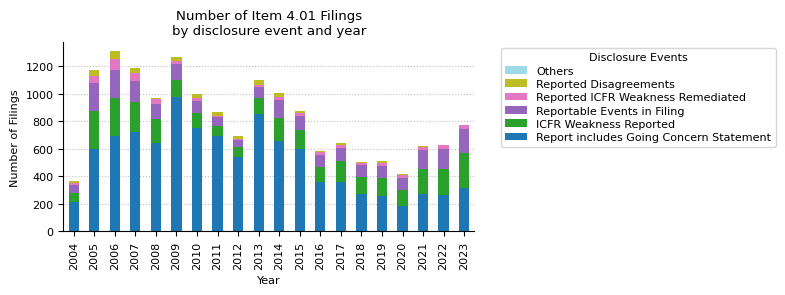

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))

top_5_events.drop(columns="total").T.plot(kind="bar", stacked=True, ax=ax, cmap="tab20")

ax.set_title("Number of Item 4.01 Filings\nby disclosure event and year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    reversed(handles),
    reversed(labels),
    title="Disclosure Events",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Disagreements


In [17]:
disagreements_year_pivot = pd.pivot_table(
    structured_data,
    index="year",
    values=["reportedDisagreements", "resolvedDisagreements"],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)


disagreements_year_pivot = disagreements_year_pivot.T
disagreements_year_pivot["total"] = disagreements_year_pivot.sum(axis=1)
disagreements_year_pivot = disagreements_year_pivot.sort_values(
    by="total", ascending=False
)
disagreements_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,total
reportedDisagreements,16,47,55,38,11,28,32,28,20,31,...,14,7,14,7,14,8,5,5,4,410
resolvedDisagreements,9,25,26,16,6,11,11,0,5,17,...,6,0,4,4,5,4,1,0,0,157


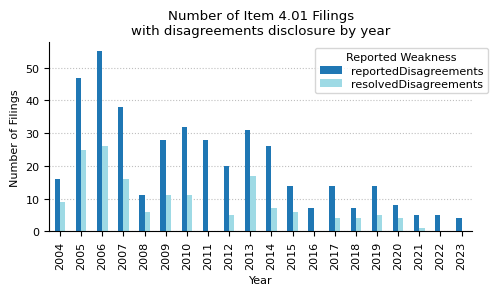

In [18]:
fig, ax = plt.subplots(figsize=(5, 3))

disagreements_year_pivot.T.drop("total").plot(
    kind="bar", stacked=False, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nwith disagreements disclosure by year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    handles,
    labels,
    title="Reported Weakness",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## ICFR Weaknesses


In [19]:
icfr_weaknesses_pivot = pd.pivot_table(
    structured_data,
    index="year",
    values=[
        "remediatedIcfrWeakness",
        "reportedIcfrWeakness",
    ],
    aggfunc=lambda x: (x == True).sum(),
    fill_value=0,
)


icfr_weaknesses_pivot = icfr_weaknesses_pivot.T
icfr_weaknesses_pivot["total"] = icfr_weaknesses_pivot.sum(axis=1)
icfr_weaknesses_pivot = icfr_weaknesses_pivot.sort_values(by="total", ascending=False)
icfr_weaknesses_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,total
reportedIcfrWeakness,61,270,275,219,172,122,111,74,68,117,...,139,109,148,125,125,118,182,188,255,3044
remediatedIcfrWeakness,16,49,77,55,36,25,20,12,7,20,...,17,22,25,20,20,23,25,29,25,549


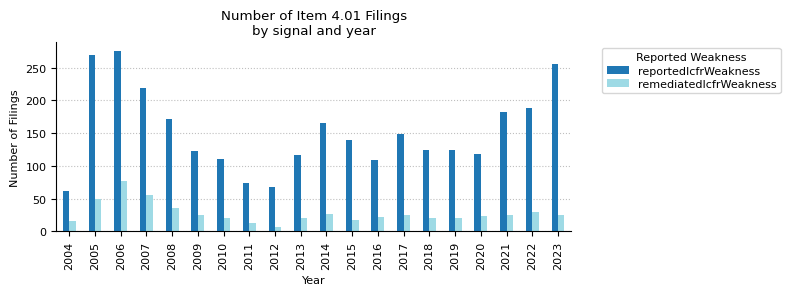

In [20]:
fig, ax = plt.subplots(figsize=(8, 3))

icfr_weaknesses_pivot.T.drop("total").plot(
    kind="bar", stacked=False, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nby signal and year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    handles,
    labels,
    title="Reported Weakness",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Reason for End of Engagement


In [21]:
engagementEndReason = (
    structured_data["engagementEndReason"].explode().value_counts().to_frame().head(5)
)
engagementEndReason.index.name = "Audit Opinion Type"
engagementEndReason.columns = ["Count"]
engagementEndReason["Pct."] = (
    engagementEndReason["Count"] / engagementEndReason["Count"].sum() * 100
)
engagementEndReason["Pct."] = engagementEndReason["Pct."].round(1)
engagementEndReason["Count"] = engagementEndReason["Count"].apply(lambda x: f"{x:,.0f}")

print(
    f"Top 4 reason for end of engagement with the former accountant if stated in the Item 4.01 filings (2004 - 2023):"
)
engagementEndReason.head(4)

Top 4 reason for end of engagement with the former accountant if stated in the Item 4.01 filings (2004 - 2023):


,Count,Pct.
Audit Opinion Type,,
dismissal,"14,306",65.1
resignation,"5,923",27.0
declination to stand for reappointment,"1,146",5.2
dissolution,595,2.7


In [22]:
endReason_year = structured_data[
    ["engagementEndReason", "year", "accessionNo"]
].explode("engagementEndReason")

endReason_year_pivot = pd.pivot_table(
    endReason_year,
    index="engagementEndReason",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

endReason_year_pivot["total"] = endReason_year_pivot.sum(axis=1)
endReason_year_pivot = endReason_year_pivot.sort_values(by="total", ascending=False)
# remove artifacts
endReason_year_pivot = endReason_year_pivot[
    endReason_year_pivot["total"] >= 0.001 * endReason_year_pivot["total"].sum()
]

endReason_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,total
engagementEndReason,,,,,,,,,,,,,,,,,,,,,
dismissal,364,969,1150,1046,925,1313,912,891,722,879,...,644,540,538,455,412,400,496,455,482,14306
resignation,214,538,522,474,389,380,347,281,231,359,...,324,229,243,215,180,107,124,161,187,5923
declination to stand for reappointment,39,176,100,78,48,50,97,44,30,103,...,65,35,34,29,21,16,29,36,59,1146
dissolution,4,19,50,60,28,107,33,47,45,48,...,15,30,16,5,4,6,7,29,18,595


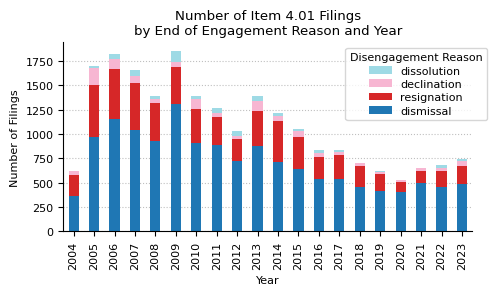

In [23]:
fig, ax = plt.subplots(figsize=(5, 3))

endReason_year_pivot.drop(columns="total").T.plot(
    kind="bar", stacked=True, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nby End of Engagement Reason and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    reversed(handles),
    reversed(labels),
    title="Disengagement Reason",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()

## Opinion Types of Audit Reports


In [24]:
opinionType = structured_data["opinionType"].explode().value_counts().to_frame().head(5)
opinionType.index.name = "Audit Opinion Type"
opinionType.columns = ["Count"]
opinionType["Pct."] = opinionType["Count"] / opinionType["Count"].sum() * 100
opinionType["Pct."] = opinionType["Pct."].round(1)
opinionType["Count"] = opinionType["Count"].apply(lambda x: f"{x:,.0f}")

print(
    f"Opinion types of the audit reports if stated in the Item 4.01 filings (2004 - 2023):"
)
opinionType

Opinion types of the audit reports if stated in the Item 4.01 filings (2004 - 2023):


,Count,Pct.
Audit Opinion Type,,
unqualified,"17,473",97.2
qualified,462,2.6
adverse,37,0.2


In [25]:
opinionType_year = structured_data[["opinionType", "year", "accessionNo"]].explode(
    "opinionType"
)

opinionType_year_pivot = pd.pivot_table(
    opinionType_year,
    index="opinionType",
    columns="year",
    values="accessionNo",
    aggfunc="count",
    fill_value=0,
)

opinionType_year_pivot["total"] = opinionType_year_pivot.sum(axis=1)
opinionType_year_pivot = opinionType_year_pivot.sort_values(by="total", ascending=False)
# remove artifacts
opinionType_year_pivot = opinionType_year_pivot[
    opinionType_year_pivot["total"] >= 0.001 * opinionType_year_pivot["total"].sum()
]

opinionType_year_pivot

year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,total
opinionType,,,,,,,,,,,,,,,,,,,,,
unqualified,501,1350,1406,1273,1105,1354,1159,1005,828,1114,...,862,669,668,548,491,447,581,575,591,17473
qualified,13,61,46,39,38,55,42,31,19,25,...,16,12,9,8,6,2,6,8,3,462
adverse,0,4,2,5,0,1,0,2,3,5,...,0,0,1,3,4,1,1,2,2,37


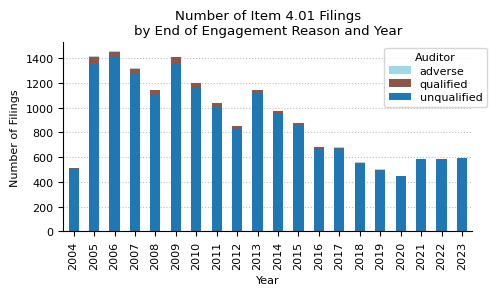

In [26]:
fig, ax = plt.subplots(figsize=(5, 3))

opinionType_year_pivot.drop(columns="total").T.plot(
    kind="bar", stacked=True, ax=ax, cmap="tab20"
)

ax.set_title("Number of Item 4.01 Filings\nby End of Engagement Reason and Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Filings")
ax.xaxis.grid(False)
ax.set_axisbelow(True)
handles, labels = ax.get_legend_handles_labels()  # reverse order of legend items

labels = [
    "declination" if label == "declination to stand for reappointment" else label
    for label in labels
]

ax.legend(
    reversed(handles),
    reversed(labels),
    title="Auditor",
    bbox_to_anchor=(1.05, 1),
    labelspacing=0.3,
    fontsize=8,
)

plt.tight_layout()
plt.show()